In [1]:
import argparse
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from scipy.signal import savgol_filter
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import math
import os

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print('Using CUDA')

Using CUDA


In [0]:
class Net(nn.Module):   #Best Model
    # def __init__(self, layers, hidden_size, num_kernel, batch_norm):
    #     super(Net, self).__init__()
    #     self.layers = layers
    #     self.hidden_size = hidden_size
    #     self.num_kernel = num_kernel
    #     self.batch_norm = batch_norm
    #     self.pool = nn.MaxPool2d(2, 2)

    #     self.conv1 = nn.Sequential(nn.Conv2d(3, num_kernel, 7), nn.BatchNorm2d(num_kernel))
    #     self.conv2 = nn.Sequential(nn.Conv2d(num_kernel, num_kernel, 6), nn.ReLU(), nn.BatchNorm2d(num_kernel))
    #     self.conv3 = nn.Sequential(nn.Conv2d(num_kernel, num_kernel, 6), nn.ReLU(), nn.BatchNorm2d(num_kernel))
    #     self.conv4 = nn.Sequential(nn.Conv2d(num_kernel, num_kernel, 4), nn.ReLU(), nn.BatchNorm2d(num_kernel))
    #     self.conv5 = nn.Sequential(nn.Conv2d(num_kernel, num_kernel, 3), nn.ReLU(), nn.BatchNorm2d(num_kernel))

    #     self.dropout = nn.Dropout(0.2)

    #     self.flat_size = num_kernel * 68 * 68
    #     self.fc1 = nn.Sequential(nn.Linear(self.flat_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size))
    #     # self.fc2 = nn.Linear(100, hidden_size)
    #     self.fc3 = nn.Linear(hidden_size, 6)

    # def forward(self, x):
    #     x = self.conv1(x)
    #     x = self.dropout(x)
    #     x = self.conv2(x)
    #     x = self.dropout(x)
    #     x = self.pool(self.conv3(x))
    #     x = self.dropout(x)
    #     x = self.conv4(x)
    #     x = self.dropout(x)
    #     x = self.pool(self.conv5(x))
    #     x = self.dropout(x)
    #     print(x.size())
    #     x = x.view(-1, self.flat_size)
    #     x = self.fc1(x)
    #     x = self.dropout(x)
    #     # x = F.relu(self.fc2(x))
    #     x = self.fc3(x)
    #     return x

    def __init__(self, layers, hidden_size, num_kernel, batch_norm):
        super(Net, self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.num_kernel = num_kernel
        self.batch_norm = batch_norm
        self.conv1 = nn.Conv2d(3, num_kernel, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(num_kernel)
        self.bn2 = nn.BatchNorm2d(num_kernel)
        self.conv2 = nn.Conv2d(num_kernel, num_kernel, 10)
        self.fc1 = nn.Linear(num_kernel*68*68, 100) 
        self.fc2 = nn.Linear(100, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 6)
        self.fc1_bn = nn.BatchNorm1d(100)
        self.fc2_bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.dropout(self.pool(F.relu(self.bn1(self.conv1(x)))))
        x = self.dropout(self.pool(F.relu(self.bn2(self.conv2(x)))))
        x = x.view(-1, 68*68*self.num_kernel) # 42 * 42 * self.num_kernel
        x = self.dropout(F.relu(self.fc1_bn(self.fc1(x))))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 1693440)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        return x

   



def one_hot(x):
    encoded = torch.zeros(10)
    encoded[x] = 1
    return encoded

def decode(one_hot, size):
    print(one_hot)
    one_hot = one_hot.tolist()
    corr = []
    for i in range(size):
        corr.append(one_hot[i].index(max(one_hot[i])))
    return corr
def evaluate(loader, net):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            # print(predicted.shape, labels.shape)
            correct += (predicted == labels.max(axis=1)[1]).sum().item()
    #print(correct/len(loader.dataset))
    return correct/len(loader.dataset)


def evaluate_ce(loader, net):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i,data in enumerate(loader,0):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct/total

#
def eval_loss(loader, net):
    net.eval()
    total = 0
    total_loss = 0
    for i, data in enumerate(loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        # print(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        # print(len(outputs), len(labels))
        loss = criterion(input=outputs, target=labels).mean()
        total_loss += loss
        total += 1
        torch.cuda.empty_cache
    return total_loss/total

def imshow(img):    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [3]:
hidden_size = 32
layers = 2
num_kernel = 10
batch_norm = True
batch_size = 112
lr = 0.0001
seed = 5
epochs = 20

root = '/content/dataset_era_535'
print(os.getcwd())
torch.manual_seed(seed)
data = datasets.ImageFolder(root, transform=transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(data, batch_size=1370, shuffle=True)
print(len(data_loader.dataset))
mean = 0.0
std = 0.0
max_valid_acc = 0
for files, _ in data_loader:
    samples = files.size(0)
    files = files.view(samples, files.size(1), -1)
    mean += files.mean(2).sum(0)
    std += files.std(2).sum(0)
mean /= len(data_loader.dataset)
std /= len(data_loader.dataset)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
data = datasets.ImageFolder(root, transform=transform)
print(len(data_loader.dataset))
train, validate = train_test_split(data, test_size=0.2, random_state=1)
# train, overfit = train_test_split(train, test_size=0.001, random_state=1)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validate, batch_size=batch_size, shuffle=True)
# overfit_loader = torch.utils.data.DataLoader(overfit, batch_size=batch_size, shuffle=True)

/content
3210
3210


4


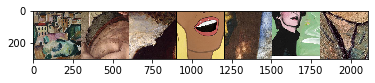

Cubism Post_Impressionism Fauvism Impressionism Cubism Impressionism Pop_Art


In [4]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(len(images[0:4]))
classes = ["Baroque", "Cubism", "Fauvism", "Impressionism", "Pop_Art", "Post_Impressionism",  "Renaissance"]

# show images
imshow(torchvision.utils.make_grid(images[0:7]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(7)))

In [0]:
net = Net(layers=layers, hidden_size=hidden_size, batch_norm=batch_norm, num_kernel=num_kernel)
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)

Finished Training
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 290, 290]           3,010
       BatchNorm2d-2         [-1, 10, 290, 290]              20
         MaxPool2d-3         [-1, 10, 145, 145]               0
           Dropout-4         [-1, 10, 145, 145]               0
            Conv2d-5         [-1, 10, 136, 136]          10,010
       BatchNorm2d-6         [-1, 10, 136, 136]              20
         MaxPool2d-7           [-1, 10, 68, 68]               0
           Dropout-8           [-1, 10, 68, 68]               0
            Linear-9                  [-1, 100]       4,624,100
      BatchNorm1d-10                  [-1, 100]             200
          Dropout-11                  [-1, 100]               0
           Linear-12                   [-1, 32]           3,232
      BatchNorm1d-13                   [-1, 32]              64
           Linear-14 

ValueError: ignored

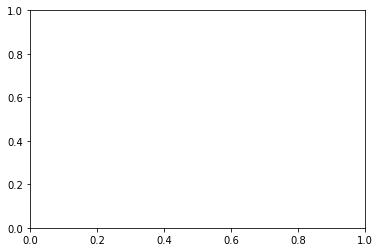

In [7]:

# net = Net(layers=layers, hidden_size=hidden_size, batch_norm=batch_norm, num_kernel=num_kernel)
# net.cuda()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
# t = 0
total_train_acc = []
total_valid_acc = []
total_loss = []
total_valid_loss = []
true = []
predict = []
start = time.time()
time.clock()
for e in range(epochs):  # loop over the dataset multiple times
    accum_loss = 0.0
    tot_corr = 0
    break
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        # print(labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        # print(len(outputs), len(labels))
        loss = criterion(input=outputs, target=labels).mean()
        loss.backward()
        optimizer.step()
        # print statistics
        accum_loss += loss
        labels = torch.cuda.FloatTensor(labels.float())
        true.extend(labels)
        _, predicted = torch.max(outputs.data, 1)
        predict.extend(predicted)
        torch.cuda.empty_cache
        break
    # labels_decoded = decode(labels, labels.shape[0])
    # valid_loss = eval_loss(valid_loader, net)
    # total_valid_loss.append(valid_loss)
    valid_acc = evaluate_ce(valid_loader, net)
    # # if valid_acc > max_valid_acc:
    # #     torch.save(net.state_dict(), 'MyBestSmall.pt')
    # #     max_valid_acc = valid_acc
    total_valid_acc.append(valid_acc)
    total_loss.append(loss)
    train_acc = evaluate_ce(train_loader, net)
    total_train_acc.append(train_acc)
    print(e)
    print('Epoch {} | Training Loss: {:.5f} | Training Acc: {:.1f}% | Valid Acc: {:.1f}% |'.format(
        e + 1, accum_loss / (i + 1), train_acc * 100, valid_acc * 100))
# Valid Loss: {:.5f} | 
print('Finished Training')
summary(net, input_size=(3, 299, 299))
# print(time.time() - start)
# print(max(total_valid_acc))
# total_loss = savgol_filter(total_loss, 5, 3)
# total_valid_loss = savgol_filter(total_valid_loss, 5, 3)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(0, epochs), total_loss, label='Training Data')
# ax.plot(range(0, epochs), total_valid_loss, label='Validation Data')
plt.title('Over Fitting: Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
ax.legend()
plt.savefig("loss_bb_valid300.png")
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(0, epochs), total_train_acc,
        label='Training Data')
ax.plot(range(0, epochs), total_valid_acc,
        label='Validation Data')
# ax.plot(range(0, len(total_train_acc) * args.eval_every, args.eval_every), total_train_acc,
#         label='Training Data')
# ax.plot(range(0, len(total_valid_acc) * args.eval_every, args.eval_every), total_valid_acc,
#         label='Validation Data ')
plt.ylim(0, 1)
plt.title('Preliminary Training and Validation: Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
ax.legend()
plt.savefig("acc_bb_valid300.png")
true = [true[i].item() for i in range(len(true))]
predict = [predict[i].item() for i in range(len(predict))]
print(confusion_matrix(true, predict))
plt.show()